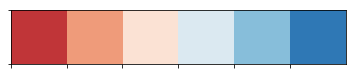

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white", palette=sns.palplot(sns.color_palette("RdBu")))

import numpy as np
import pandas as pd
import scipy.io as sio

import sys
sys.path.append('..')

from helper import recommender as rcmd

# load data and setting up

In [2]:
movies_mat = sio.loadmat('./data/ex8_movies.mat')
Y, R = movies_mat.get('Y'), movies_mat.get('R')

Y.shape, R.shape

((1682, 943), (1682, 943))

In [3]:
m, u = Y.shape
# m: how many movies
# u: how many users

n = 10  # how many features for a movie

In [4]:
param_mat = sio.loadmat('./data/ex8_movieParams.mat')
theta, X = param_mat.get('Theta'), param_mat.get('X')

theta.shape, X.shape

((943, 10), (1682, 10))

# cost
<img style="float: left;" src="../img/rcmd_cost.png">

In [5]:
# use subset of data to calculate the cost as in pdf...
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
theta_sub = theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

param_sub = rcmd.serialize(X_sub, theta_sub)

rcmd.cost(param_sub, Y_sub, R_sub, features)

22.224603725685675

In [6]:
param = rcmd.serialize(X, theta)  # total real params

rcmd.cost(rcmd.serialize(X, theta), Y, R, 10)  # this is real total cost

27918.64012454421

# gradient
<img style="float: left;" src="../img/rcmd_gradient.png">

In [7]:
n_movie, n_user = Y.shape

X_grad, theta_grad = rcmd.deserialize(rcmd.gradient(param, Y, R, 10),
                                      n_movie, n_user, 10)

<img style="float: left;" src="../img/rcmd_vectorized_grad.png">

In [8]:
assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

# regularized cost

In [9]:
# in the ex8_confi.m, lambda = 1.5, and it's using sub data set
rcmd.regularized_cost(param_sub, Y_sub, R_sub, features, l=1.5)

31.34405624427422

In [10]:
rcmd.regularized_cost(param, Y, R, 10, l=1)  # total regularized cost

32520.682450229557

# regularized gradient

<img style="float: left;" src="../img/rcmd_reg_grad.png">

In [11]:
n_movie, n_user = Y.shape

X_grad, theta_grad = rcmd.deserialize(rcmd.regularized_gradient(param, Y, R, 10),
                                                                n_movie, n_user, 10)

assert X_grad.shape == X.shape
assert theta_grad.shape == theta.shape

# parse `movie_id.txt`

In [12]:
movie_list = []

with open('./data/movie_ids.txt', encoding='latin-1') as f:
    for line in f:
        tokens = line.strip().split(' ')
        movie_list.append(' '.join(tokens[1:]))

movie_list = np.array(movie_list)

# reproduce my ratings

In [13]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

# prepare data

In [14]:
Y, R = movies_mat.get('Y'), movies_mat.get('R')


Y = np.insert(Y, 0, ratings, axis=1)  # now I become user 0
Y.shape

(1682, 944)

In [15]:
R = np.insert(R, 0, ratings != 0, axis=1)
R.shape

(1682, 944)

In [16]:
n_features = 50
n_movie, n_user = Y.shape
l = 10

In [17]:
X = np.random.standard_normal((n_movie, n_features))
theta = np.random.standard_normal((n_user, n_features))

X.shape, theta.shape

((1682, 50), (944, 50))

In [18]:
param = rcmd.serialize(X, theta)

normalized ratings

In [19]:
Y_norm = Y - Y.mean()
Y_norm.mean()

4.6862111343939375e-17

# training

In [20]:
import scipy.optimize as opt

In [21]:
res = opt.minimize(fun=rcmd.regularized_cost,
                   x0=param,
                   args=(Y_norm, R, n_features, l),
                   method='TNC',
                   jac=rcmd.regularized_gradient)

In [22]:
res

     fun: 64721.49781506804
     jac: array([-7.98248019e-07, -3.69733351e-08, -1.88994213e-06, ...,
        8.66793365e-07,  1.09219072e-07,  1.58348824e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2624
     nit: 81
  status: 1
 success: True
       x: array([ 0.13746203,  0.2447696 , -0.54489735, ..., -0.41465037,
       -0.22445536,  0.08372089])

In [23]:
X_trained, theta_trained = rcmd.deserialize(res.x, n_movie, n_user, n_features)
X_trained.shape, theta_trained.shape

((1682, 50), (944, 50))

In [24]:
prediction = X_trained @ theta_trained.T

In [25]:
my_preds = prediction[:, 0] + Y.mean()

In [26]:
idx = np.argsort(my_preds)[::-1]  # Descending order
idx.shape

(1682,)

In [27]:
# top ten idx
my_preds[idx][:10]

array([4.12534035, 4.04414522, 3.9932466 , 3.91902652, 3.81691626,
       3.81556059, 3.76602539, 3.76323003, 3.75904988, 3.75076965])

In [28]:
for m in movie_list[idx][:10]:
    print(m)

Titanic (1997)
Star Wars (1977)
Shawshank Redemption, The (1994)
Forrest Gump (1994)
Raiders of the Lost Ark (1981)
Braveheart (1995)
Return of the Jedi (1983)
Usual Suspects, The (1995)
Godfather, The (1972)
Schindler's List (1993)
